In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [78]:
dataset_path = keras.utils.get_file(
    "auto-mpg.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
)

print("Dataset path: ", dataset_path)

Dataset path:  C:\Users\Ridzuan\.keras\datasets\auto-mpg.data


In [79]:
column_names = [
    "MPG",
    "Cylinder",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin"
]

raw_dataset = pd.read_csv(
    dataset_path,
    names = column_names,
    na_values = "?",
    comment = "\t",
    sep = " ",
    skipinitialspace = True
)

dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinder,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Check for missing values

Unknown or missing values need to be preprocessed before it can be trained. One of the method is by dropping rows that contains missing information.

In [80]:
# check for missing information
pd.DataFrame(dataset.isna().sum())

,0
MPG,0
Cylinder,0
Displacement,0
Horsepower,6
Weight,0
Acceleration,0
Model Year,0
Origin,0


In [81]:
dataset = dataset.dropna()
pd.DataFrame(dataset.isna().sum())

,0
MPG,0
Cylinder,0
Displacement,0
Horsepower,0
Weight,0
Acceleration,0
Model Year,0
Origin,0


## One-hot-encoding

```Origin``` column is categorical. These rows of numerical value will be converted into ```label``` using one-hot-encode mapping.

In [82]:
dataset["Origin"] = dataset["Origin"].map(
    lambda x: {1: "USA", 2: "Europe", 3: "Japan"}
    .get(x)
)

In [83]:
dataset= pd.get_dummies(dataset, prefix = "", prefix_sep = "")
dataset.tail()

,MPG,Cylinder,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [84]:
# split data into training and test set
train_dataset = dataset.sample(frac = 0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

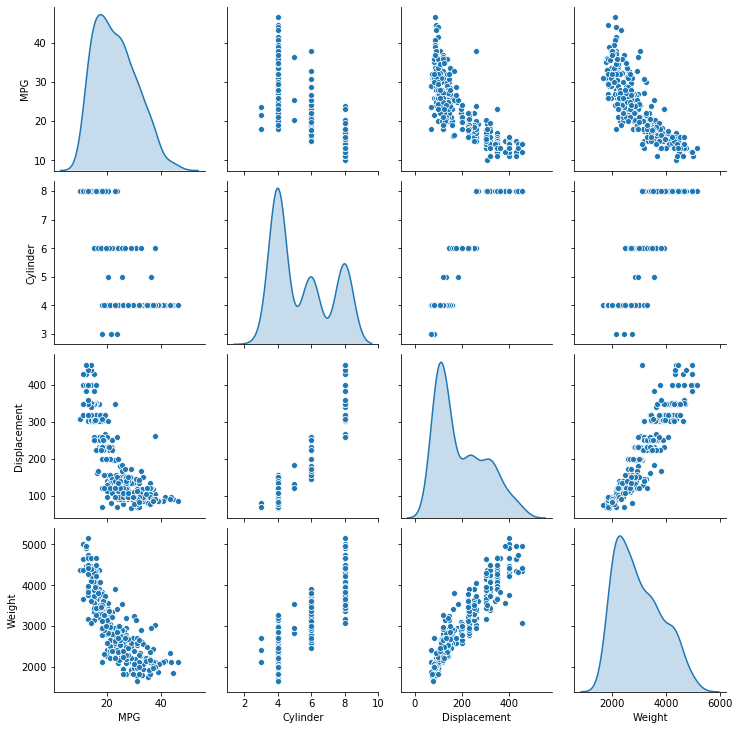

In [85]:
# data inspection
sns.pairplot(
    train_dataset[[
        "MPG",
        "Cylinder",
        "Displacement",
        "Weight"
    ]], 
    diag_kind = "kde"
)

In [86]:
# overall statistics
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinder,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Split features from labels

Separate the target value or label from the features. This label is the value that will be used to train the model.

In [87]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

## Data normalization

Normalize the features that use different scales and ranges.

$$ N(0,1) = \frac{X - \mu}{\sigma} $$

In [88]:
def norm(x):
    return (x - train_stats["mean"])/train_stats["std"]

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [127]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(
    loss = "mse",
    optimizer = optimizer,
    metrics = ["mae", "mse"]
)

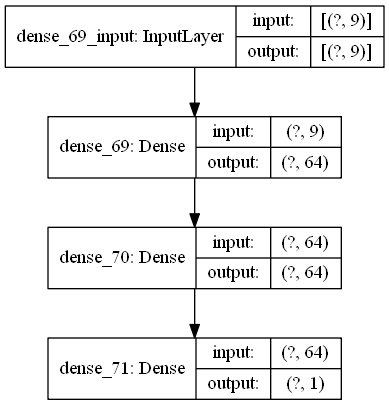

In [128]:
from tensorflow.keras.utils import plot_model
import os

# add Grpahwiz to path variable
os.environ["PATH"] += os.pathsep + "D:/Program Files (x86)/Graphviz2.38/bin/"

plot_model(
    model,
    show_shapes = True,
    expand_nested = True
)

In [129]:
epochs = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs = epochs,
    validation_split = 0.2,
    verbose = 0,
    callbacks = [tfdocs.modeling.EpochDots()]
)


Epoch: 0, loss:578.1121,  mae:22.8150,  mse:578.1121,  val_loss:564.8440,  val_mae:22.5505,  val_mse:564.8440,  
....................................................................................................
Epoch: 100, loss:6.3135,  mae:1.7560,  mse:6.3135,  val_loss:9.2484,  val_mae:2.3393,  val_mse:9.2484,  
....................................................................................................
Epoch: 200, loss:5.3747,  mae:1.6300,  mse:5.3747,  val_loss:8.3931,  val_mae:2.2648,  val_mse:8.3931,  
....................................................................................................
Epoch: 300, loss:5.1251,  mae:1.5334,  mse:5.1251,  val_loss:8.2753,  val_mae:2.2335,  val_mse:8.2753,  
....................................................................................................
Epoch: 400, loss:4.7386,  mae:1.4530,  mse:4.7386,  val_loss:9.0023,  val_mae:2.2400,  val_mse:9.0023,  
..............................................................

In [130]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.771462,1.066931,2.771461,9.694077,2.387276,9.694077,995
996,2.786704,1.032843,2.786704,9.920371,2.406526,9.920370,996
997,2.686089,1.043648,2.686089,10.228440,2.460541,10.228440,997
998,2.786276,1.048021,2.786276,9.922413,2.425336,9.922414,998
999,2.698025,1.020753,2.698025,9.650893,2.395145,9.650893,999


Text(0, 0.5, 'MAE (MPG)')

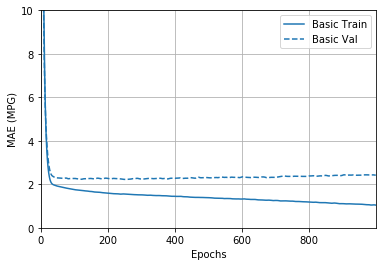

In [131]:
plt.figure()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std = 2)
plotter.plot(
    {"Basic": history},
    metric = "mae"
)
plt.ylim([0, 10])
plt.ylabel("MAE (MPG)")

Text(0, 0.5, 'MSE (MPG)')

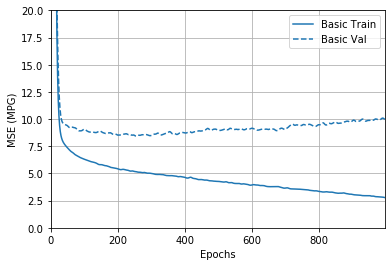

In [132]:
plt.figure()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std = 2)
plotter.plot(
    {"Basic": history},
    metric = "mse"
)
plt.ylim([0, 20])
plt.ylabel("MSE (MPG)")

The graph shows degradation after about 100 epochs. ```model.fit``` will be updated to automatically stop training when the validation score doesnt improve.
```EarlyStopping``` callback will be used to test the training condition for every epoch. If a set amount of epochs elapsed without showing imrprovement, the training will be stopped.

In [134]:
early_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

optimizer = keras.optimizers.RMSprop(0.001)

early_model.compile(
    loss = "mse",
    optimizer = optimizer,
    metrics = ["mae", "mse"]
)

early_stop = keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 10
)

early_history = early_model.fit(
    normed_train_data, 
    train_labels, 
    epochs = 100, 
    validation_split = 0.2, 
    verbose=0,       
    callbacks=[
        early_stop,
        tfdocs.modeling.EpochDots()
    ]
)


Epoch: 0, loss:548.6651,  mae:22.1127,  mse:548.6651,  val_loss:529.8523,  val_mae:21.6394,  val_mse:529.8523,  
.................................................................

Text(0, 0.5, 'MAE [MPG]')

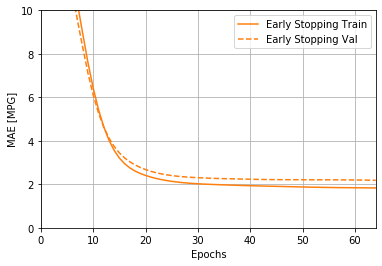

In [135]:
plt.figure()
plotter.plot(
    {
        "Early Stopping": early_history
    },
    metric = "mae"
)
plt.ylim([0, 10])
plt.ylabel("MAE [MPG]")

In [139]:
loss, mae, mse = early_model.evaluate(
    normed_test_data,
    test_labels,
    verbose = 2
)

print("Testing set Mean Absolute Error {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.5198 - mae: 2.0264 - mse: 6.5198
Testing set Mean Absolute Error  2.03 MPG


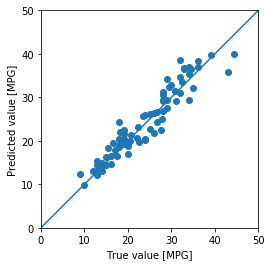

In [140]:
test_prediction = model.predict(normed_test_data).flatten()

plt.figure()
axis = plt.axes(aspect = "equal")
plt.scatter(test_labels, test_prediction)
plt.xlabel("True value [MPG]")
plt.ylabel("Predicted value [MPG]")
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)
plt.show()

Text(0, 0.5, 'Count')

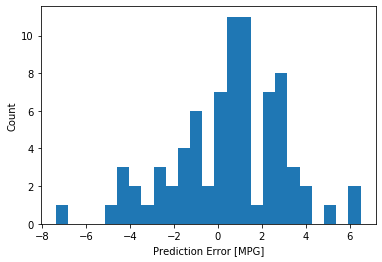

In [142]:
error = test_prediction - test_labels
plt.figure()
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")